In [2]:
import warnings

warnings.filterwarnings('ignore')

import os

from tools.modeling.timeserieshyperparamtuner import TimeSeriesHyperParamTuner
from tools.modeling.timeseriesmodeler import TimeSeriesModeler

from nba.common import add_game_log_lag, add_game_log_last_5
import nba.constants as c

from xgboost import XGBRegressor
from hyperopt import hp

import numpy as np
import pandas as pd

import shap


ROOT_DIR = os.getcwd()[:-17] # verify this points to the root directory of the project

season = c.SEASON_2022_2023

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [3]:
# Get all players game logs for the top 100 scorers of the season
# df = get_all_players_by_season(season)
# df = df.loc[df[c.GP] >= 30]
# df = df.sort_values(by=c.PTS, ascending=False)
# player_ids = df[c.PLAYER_ID].head(100).tolist()
# logs = get_players_game_log(player_ids, season)
# logs.to_csv(ROOT_DIR + '/data/game_logs/{season}/top_100_scorers_{season}_game_log.csv'.format(season=season), index=False)

In [4]:
logs = pd.read_csv(ROOT_DIR + '/data/game_logs/{season}/top_100_scorers_{season}_game_log.csv'.format(season=season))
logs

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON
0,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201198,2023-04-06,PHI vs. MIA,L,...,2,2,0,2,0,1,4,21,-11,2022-23
1,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201181,2023-04-04,PHI vs. BOS,W,...,6,3,0,2,1,3,9,52,17,2022-23
2,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201174,2023-04-02,PHI @ MIL,L,...,5,1,0,0,1,4,4,28,-10,2022-23
3,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201150,2023-03-31,PHI vs. TOR,W,...,1,5,0,1,0,3,6,25,0,2022-23
4,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201139,2023-03-29,PHI vs. DAL,W,...,3,4,1,1,1,4,6,25,10,2022-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200072,2022-10-28,CLE @ BOS,W,...,2,0,0,0,0,2,2,12,25,2022-23
6577,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200056,2022-10-26,CLE vs. ORL,W,...,1,1,1,1,0,5,5,18,11,2022-23
6578,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200039,2022-10-23,CLE vs. WAS,W,...,3,0,0,2,1,2,4,15,-1,2022-23
6579,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200032,2022-10-22,CLE @ CHI,W,...,2,2,0,1,0,2,3,8,5,2022-23


In [5]:
logs[c.GAME_DATE] = pd.to_datetime(logs[c.GAME_DATE])
logs = add_game_log_last_5(logs)
logs = add_game_log_lag(logs)

logs.sort_values(by=[c.GAME_DATE])
logs

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FG_PCT_LAG,FGM_LAG,FGA_LAG,FG3M_LAG,FG3A_LAG,FG3_PCT_LAG,FTM_LAG,FTA_LAG,FT_PCT_LAG,PLUS_MINUS_LAG
552,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200002,2022-10-18,LAL @ GSW,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200016,2022-10-20,LAL vs. LAC,L,...,0.462,12.0,26.0,3.0,10.0,0.300,4.0,4.0,1.000,-10.0
550,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200037,2022-10-23,LAL vs. POR,L,...,0.412,7.0,17.0,2.0,8.0,0.250,4.0,6.0,0.667,-1.0
549,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200064,2022-10-26,LAL @ DEN,L,...,0.545,12.0,22.0,2.0,9.0,0.222,5.0,7.0,0.714,2.0
548,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200076,2022-10-28,LAL @ MIN,L,...,0.381,8.0,21.0,2.0,8.0,0.250,1.0,2.0,0.500,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201149,2023-03-31,IND vs. OKC,W,...,0.524,11.0,21.0,1.0,5.0,0.200,6.0,9.0,0.667,-11.0
4799,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201173,2023-04-02,IND @ CLE,L,...,0.625,5.0,8.0,1.0,3.0,0.333,4.0,5.0,0.800,-9.0
4798,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201190,2023-04-05,IND vs. NYK,L,...,0.417,5.0,12.0,1.0,2.0,0.500,8.0,8.0,1.000,-7.0
4797,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201203,2023-04-07,IND vs. DET,L,...,0.353,6.0,17.0,1.0,3.0,0.333,4.0,6.0,0.667,-31.0


In [6]:
# Preprocess Data
PTS_PREDICTION_MASK = [c.PTS] + c.GAME_LOG_LAG_MASK + c.GAME_LOG_LAST_5_MASK
logs = logs[PTS_PREDICTION_MASK]
logs.dropna()

cats = logs.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    logs[col] = logs[col].astype('category')

In [7]:
rmse = {
    'base_model': 0,
    'tuned_model': 0,
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000
}

In [8]:
ts_modeler = TimeSeriesModeler(XGBRegressor())
ts_modeler.ts_train(params, logs, c.PTS)
rmse['base_model'] = ts_modeler.ts_rmse()

[0]	validation_0-rmse:8.09011	validation_1-rmse:9.56683
[100]	validation_0-rmse:0.21835	validation_1-rmse:9.79342
[200]	validation_0-rmse:0.00707	validation_1-rmse:9.79521
[300]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[400]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[500]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[600]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[700]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[800]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[900]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
[999]	validation_0-rmse:0.00090	validation_1-rmse:9.79519
RSME: 9.795191716820515
[0]	validation_0-rmse:8.60631	validation_1-rmse:8.15892
[100]	validation_0-rmse:0.90523	validation_1-rmse:8.80380
[200]	validation_0-rmse:0.13035	validation_1-rmse:8.82256
[300]	validation_0-rmse:0.02069	validation_1-rmse:8.82501
[400]	validation_0-rmse:0.00340	validation_1-rmse:8.82495
[500]	validation_0-rmse:0.00109	validation_1-rmse:8.

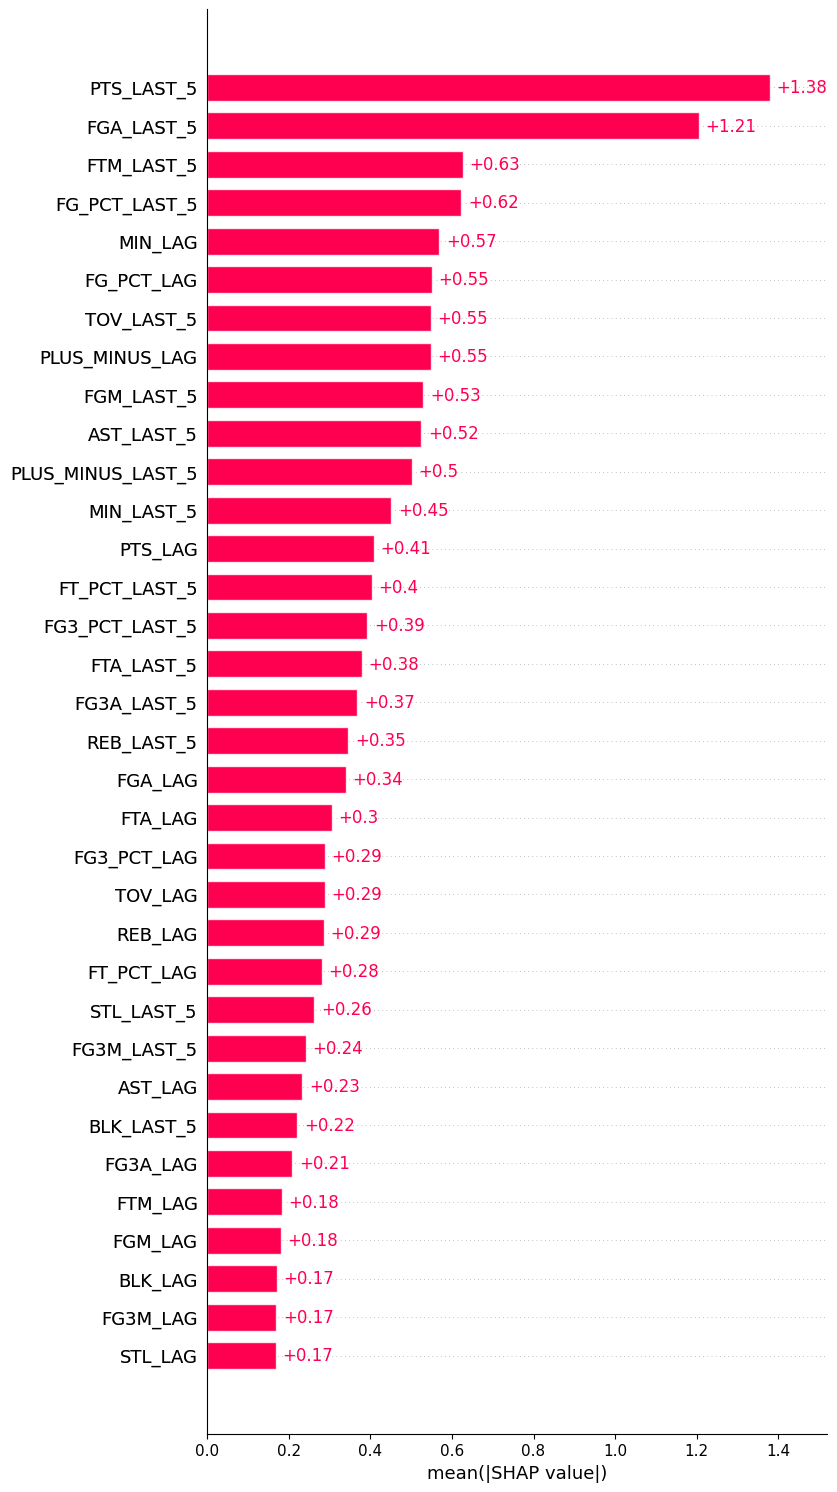

In [9]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)

In [10]:
space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
}

tuner = TimeSeriesHyperParamTuner(ts_modeler, space)
best = tuner.ts_optimize(250, logs, c.PTS)
best

[0]	validation_0-rmse:8.24171	validation_1-rmse:9.58097
[100]	validation_0-rmse:4.47114	validation_1-rmse:9.73788
[200]	validation_0-rmse:4.17465	validation_1-rmse:9.76982
[300]	validation_0-rmse:4.11058	validation_1-rmse:9.77216
[303]	validation_0-rmse:4.11058	validation_1-rmse:9.77216
RSME: 9.772155367742736                                
[0]	validation_0-rmse:8.58606	validation_1-rmse:8.13722
[100]	validation_0-rmse:4.15063	validation_1-rmse:8.50762
[200]	validation_0-rmse:3.76558	validation_1-rmse:8.60200
[300]	validation_0-rmse:3.59694	validation_1-rmse:8.61756
[303]	validation_0-rmse:3.59694	validation_1-rmse:8.61756
RSME: 8.617556183956307                                
[0]	validation_0-rmse:8.39741	validation_1-rmse:8.84387
[100]	validation_0-rmse:3.87813	validation_1-rmse:8.76089
[200]	validation_0-rmse:3.55454	validation_1-rmse:8.77229
[300]	validation_0-rmse:3.41596	validation_1-rmse:8.80636
[303]	validation_0-rmse:3.40227	validation_1-rmse:8.80665
RSME: 8.806653957291896 

{'colsample_bytree': 0.9695970481583361,
 'eta': 0.125,
 'eval_metric': 'rmse',
 'gamma': 8.849440499941773,
 'max_depth': 4.0,
 'min_child_weight': 2.0,
 'n_estimators': 668.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 158.0,
 'reg_lambda': 0.10475136325281671,
 'subsample': 0.5}

In [11]:
ts_modeler.ts_train(best, logs, c.PTS)
rmse['tuned_model'] = ts_modeler.ts_rmse()
rmse

[0]	validation_0-rmse:8.89244	validation_1-rmse:9.78311
[100]	validation_0-rmse:7.04918	validation_1-rmse:8.93556
[200]	validation_0-rmse:6.60337	validation_1-rmse:8.97654
[300]	validation_0-rmse:6.37583	validation_1-rmse:9.04922
[400]	validation_0-rmse:6.19576	validation_1-rmse:9.11655
[500]	validation_0-rmse:6.03473	validation_1-rmse:9.15550
[600]	validation_0-rmse:5.95118	validation_1-rmse:9.17208
[667]	validation_0-rmse:5.89856	validation_1-rmse:9.19788
RSME: 9.197882648012149
[0]	validation_0-rmse:9.29503	validation_1-rmse:8.30237
[100]	validation_0-rmse:7.26546	validation_1-rmse:7.98681
[200]	validation_0-rmse:6.71152	validation_1-rmse:8.08986
[300]	validation_0-rmse:6.33757	validation_1-rmse:8.13149
[400]	validation_0-rmse:6.07652	validation_1-rmse:8.15864
[500]	validation_0-rmse:5.85977	validation_1-rmse:8.18753
[600]	validation_0-rmse:5.70435	validation_1-rmse:8.21271
[667]	validation_0-rmse:5.61413	validation_1-rmse:8.22223
RSME: 8.222233257922328
[0]	validation_0-rmse:8.9700

{'base_model': 8.852474009615705, 'tuned_model': 8.467726647930744}

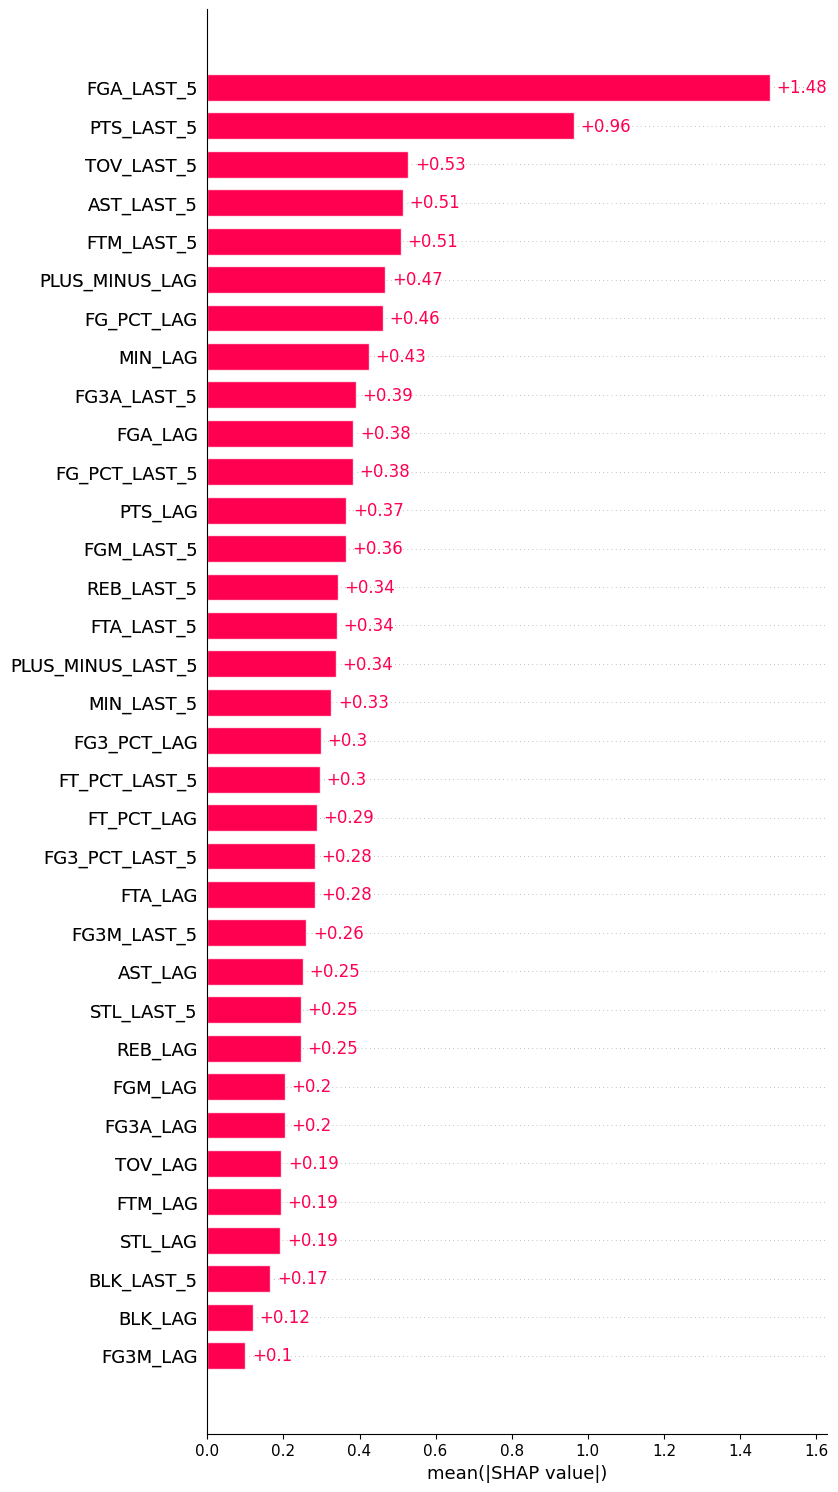

In [12]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)